# PGF5005 — Hénon–Heiles · **5.3–5.4 (v4 · ICs 2D na seção)**  
Seções de Poincaré \(p_2\times q_2\) para \(\Sigma:\ q_1=0,\ p_1\ge0\) com **amostragem 2D** de ICs na seção.

**Destaques**
- Integração com **Euler simplético (Euler–Cromer)**.
- Cruzamento \(q_1=0\) por **interpolação linear** (robusto).
- **ICs 2D**: para cada \(q_2\) permitido, varremos \(p_1\in[0,\sqrt{R(q_2)}]\) e usamos os dois sinais de \(p_2\).
- Coleta por **número de interseções** por IC (rápido e previsível).
- Presets para \(E=0.08333\) e \(E=0.125\) com salvamento automático dos PNGs.


## 1) Modelo HH e integrador Euler–Cromer

In [1]:
import math, os, time, numpy as np, matplotlib.pyplot as plt

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    q1n = q1 + dt*p1
    q2n = q2 + dt*p2
    dU1 = q1n + 2.0*q1n*q2n
    dU2 = q2n + q1n*q1n - q2n*q2n
    p1n = p1 - dt*dU1
    p2n = p2 - dt*dU2
    return q1n,q2n,p1n,p2n


## 2) Detector de seção (interpolação linear)

In [2]:
def collect_crossings(q1,q2,p1,p2, dt, N_target=600, T_max=6000.0, blowup=10.0):
    pts_q2, pts_p2 = [], []
    t = 0.0
    q1n,q2n,p1n,p2n = q1,q2,p1,p2
    while t < T_max and len(pts_q2) < N_target:
        q1m,q2m,p1m,p2m = euler_symplectic_step(q1n,q2n,p1n,p2n, dt)
        if q1n*q1m < 0.0:
            s = q1n / (q1n - q1m)
            q2_star = q2n + s*(q2m - q2n)
            p1_star = p1n + s*(p1m - p1n)
            p2_star = p2n + s*(p2m - p2n)
            if p1_star >= 0.0:
                pts_q2.append(q2_star); pts_p2.append(p2_star)
        q1n,q2n,p1n,p2n = q1m,q2m,p1m,p2m
        t += dt
        if max(abs(q1n),abs(q2n),abs(p1n),abs(p2n)) > blowup:
            break
    return np.array(pts_q2), np.array(pts_p2)


## 3) ICs na seção — amostragem 2D

In [3]:
def R_of_q2(E, q2):
    return 2*E - q2*q2 + (2.0/3.0)*q2*q2*q2

def q2_interval(E, n_samples=4000):
    q2g = np.linspace(-0.6, 1.2, n_samples)
    mask = R_of_q2(E, q2g) >= 0.0
    return q2g[mask] if mask.any() else np.array([])

def grid_ics_on_section(E, n_q2=28, n_p1=12, use_both_p2_signs=True, eps_q1=1e-6):
    q2_allowed = q2_interval(E)
    if len(q2_allowed)==0:
        return []
    q2_vals = np.linspace(q2_allowed.min(), q2_allowed.max(), n_q2)
    ics = []
    for q2 in q2_vals:
        R = R_of_q2(E, q2)
        p1_max = math.sqrt(max(0.0, R))
        if p1_max == 0.0:
            continue
        p1_vals = np.linspace(0.0, p1_max, n_p1, endpoint=True)
        for p1 in p1_vals:
            rem = max(0.0, R - p1*p1)
            p2_mag = math.sqrt(rem)
            for sgn in ([+1,-1] if use_both_p2_signs else [+1]):
                p2 = sgn*p2_mag
                ics.append( (1e-6, q2, p1, p2) )
    return ics


## 4) Construção da seção para uma energia

In [4]:
def poincare_section_energy(E, dt=5e-4, N_per_ic=400, T_max=4000.0,
                             n_q2=28, n_p1=12, both_signs=True, max_ics=None):
    ics = grid_ics_on_section(E, n_q2=n_q2, n_p1=n_p1,
                              use_both_p2_signs=both_signs, eps_q1=1e-6)
    if not ics:
        return np.array([]), np.array([])
    if max_ics is not None:
        ics = ics[:max_ics]
    all_q2, all_p2 = [], []
    for (q1,q2,p1,p2) in ics:
        q2_pts, p2_pts = collect_crossings(q1,q2,p1,p2, dt,
                                           N_target=N_per_ic, T_max=T_max, blowup=10.0)
        if len(q2_pts):
            all_q2.append(q2_pts); all_p2.append(p2_pts)
    if not all_q2:
        return np.array([]), np.array([])
    return np.concatenate(all_q2), np.concatenate(all_p2)

def plot_section(q2_pts, p2_pts, E, save=None, xlim=(-0.6,1.2), ylim=(-2.6,2.6)):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(q2_pts, p2_pts, '.', ms=0.8)
    plt.xlabel('q2 (na seção q1=0)')
    plt.ylabel('p2 (na seção q1=0)')
    plt.title(f'Secção de Poincaré (p2 × q2) — Hénon–Heiles — E={E:.5f}')
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    if save:
        os.makedirs('figs', exist_ok=True)
        plt.savefig(save, dpi=260, bbox_inches='tight')
    plt.show()


## 5) Presets para E=0.08333 e E=0.125 (gera e salva PNGs)

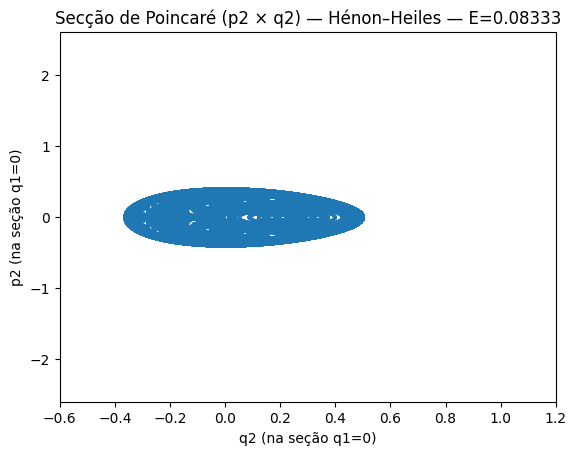

KeyboardInterrupt: 

In [5]:
dt = 5e-4
N_per_ic = 450
T_max = 3500.0
n_q2 = 26
n_p1 = 10
both_signs = True
max_ics = 520

E1, E2 = 0.08333, 0.12500

q2_1, p2_1 = poincare_section_energy(E1, dt=dt, N_per_ic=N_per_ic, T_max=T_max,
                                     n_q2=n_q2, n_p1=n_p1, both_signs=both_signs, max_ics=max_ics)
plot_section(q2_1, p2_1, E1, save='figs/HH_E_008333_v4.png')

q2_2, p2_2 = poincare_section_energy(E2, dt=dt, N_per_ic=N_per_ic, T_max=T_max,
                                     n_q2=n_q2, n_p1=n_p1, both_signs=both_signs, max_ics=max_ics)
plot_section(q2_2, p2_2, E2, save='figs/HH_E_012500_v4.png')

print('Figuras salvas em ./figs')